[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kasparvonbeelen/ghi_python/main?labpath=10_-_Hypothesis_Testing.ipynb)


# Lecture 10: Hypothesis Testing
## Data Science for Historians (with Python)
### A very gentle and practical introduction
### Created by Kaspar Beelen and Luke Blaxill

### For the German Historical Institute, London

<img align="left" src="https://www.ghil.ac.uk/typo3conf/ext/wacon_ghil/Resources/Public/Images/institute_icon_small.png">

We've covered how to describe, summarize, and compare variables. However, we lack a formal procedure to assess the importance of the differences we observe. For example, we established that men are, on average, one year younger than women. But how can we establish the value or 'significance' of this gap?

In the notebook, we move from descriptive to inferential statistics and compute the extent to which means between subgroups in our data are statistically significant.

For more background on the concepts and terminology used in this notebook, please consult the lecture by Luke Blaxill.

We repeat some of the code from the previous notebook
- load the required libraries
- load the synthetic census data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
from tqdm.notebook import tqdm
sns.set()

In [3]:
df = pd.read_csv('data/democraphic_data/london_subsample.csv',index_col=0)

To make our analysis more interesting and complex, we add a dimension: place. We study how age differences between men and women vary depending on the registration district. In Pandas, adding subgroups is convenient: simply pass a list with column names `['district', 'gender']` (instead of just one column as we've done previously). `.groupby()` will read this list from left to right, i.e. groups the data first by place and then further aggregates by `gender` within each district.

In [4]:
by_reg_gen = df.groupby(['district','gender'])['age'].mean()
by_reg_gen

district       gender
Bethnal Green  F         25.920963
               M         25.613501
               U         20.766603
Camberwell     F         27.986109
               M         26.708931
                           ...    
Whitechapel    M         26.254569
               U         24.051316
Woolwich       F         26.653639
               M         26.311769
               U         21.427165
Name: age, Length: 90, dtype: float64

Working with the output of this operation requires a bit more thought. The `.groupby()` arranges data slightly differently depending on whether you group on one column or more. This becomes apparent when printing the `type()` of the `.index` attribute.

In [5]:
type(df.groupby('gender')['age'].median().index)

pandas.core.indexes.base.Index

In [6]:
type(by_reg_gen.index)

pandas.core.indexes.multi.MultiIndex

`by_reg_gen` orders the data using a `MultiIndex`, which means that the index contains multiple levels (place and gender) via which we can access our data.

Place sits the highest level of our grouped data frame. We can access the separate districts using `.loc[]`

In [7]:
by_reg_gen.loc['Bethnal Green']

gender
F    25.920963
M    25.613501
U    20.766603
Name: age, dtype: float64

Similarly, we can slice the data by place.

In [8]:
by_reg_gen.loc['Bethnal Green':'Chelsea']

district       gender
Bethnal Green  F         25.920963
               M         25.613501
               U         20.766603
Camberwell     F         27.986109
               M         26.708931
               U         23.410050
Chelsea        F         31.318046
               M         30.430615
               U         28.800000
Name: age, dtype: float64

But our index has two levels, place **and** gender. We can obtain the means for women for all districts using the following syntax.

In [9]:
by_reg_gen.loc[:,'F']

district
Bethnal Green               25.920963
Camberwell                  27.986109
Chelsea                     31.318046
Fulham                      27.920645
Greenwich                   27.593689
Hackney                     28.796820
Hampstead                   29.742615
Holborn                     27.719117
Islington                   29.047747
Kensington                  30.823465
Lambeth                     29.019583
Lewisham                    28.879865
London City                 31.323944
Marylebone                  30.465945
Mile End Old Town           26.298023
Paddington                  30.450756
Pancras                     29.136537
Poplar                      26.384635
Shoreditch                  27.056387
Southwark                   27.144232
St George Hanover Square    30.821499
St George In The East       24.545266
St Giles                    30.129131
St Olave Southwark          26.486323
Stepney                     25.985841
Strand                      29.288732
Wan

Notice the comma in `.loc[]` (`by_reg_gen.loc[:**,**'F']`) 
- the part before the comma indicates the items we want to access from the first level (place). In this case, we entered a colon, meaning from the first till the last rows. 
- the part after the comma indicates the items we want to select from the second level. In this case, we want to retrieve all elements with value 'F' for the second level of the MultiIndex..

Computing the age differences by place is then fairly straightforward.

In [10]:
f_m_diff = by_reg_gen.loc[:,'F'] - by_reg_gen.loc[:,'M']
f_m_diff

district
Bethnal Green               0.307461
Camberwell                  1.277178
Chelsea                     0.887431
Fulham                      1.295697
Greenwich                   0.971892
Hackney                     1.357030
Hampstead                   0.645606
Holborn                     0.341140
Islington                   1.430837
Kensington                  1.410332
Lambeth                     1.411260
Lewisham                    1.420661
London City                 3.262573
Marylebone                  0.921905
Mile End Old Town           0.599087
Paddington                  1.664367
Pancras                     1.031302
Poplar                     -0.218534
Shoreditch                  0.130194
Southwark                   0.101532
St George Hanover Square    1.412338
St George In The East      -0.011402
St Giles                   -0.879827
St Olave Southwark          0.088463
Stepney                    -0.334267
Strand                     -1.759558
Wandsworth                  1

Of course, you can be more restrictive and slice the data by place and obtain only means for women.

In [11]:
by_reg_gen.loc['Bethnal Green':'Chelsea','F']

district       gender
Bethnal Green  F         25.920963
Camberwell     F         27.986109
Chelsea        F         31.318046
Name: age, dtype: float64

## Hypothesis testing

At this stage, we can compute and compare the distribution of variables, calculate their means or other relevant statistics. But a question then immediately appears: are the differences we observe "significant", and what do we mean with "significance" anyway. In this section, we have a closer look at hypothesis testing from a data-driven perspective.

Traditionally, statistical methods, such as the Student's t-test arose in times of limited computing power and relied on equations and assumptions related to the distribution of the data. Explaining this requires many detours and implies a steep learning curve for the statistically uninitiated. 

In this lecture, we explore a data-driven, and hopefully intuitive procedure, for assessing the significance of observed statistics (such as the mean). First, we discuss a procedure called **bootstrapping** and then explain how to use **permutation** for significance testing. 

The question we first address regards the relation between `gender` and `age`, and we went to assess if variations we observe over the districts is significant. We focus on Whitechapel and Poplar as we noticed in the previous section that both these districts deviate from the general pattern and contain a slightly younger female population.

The age gap is bigger in Westminster than in Poplar, but is the differences of the mean significant?

In [12]:
df_whitechapel = df[df.district=='Whitechapel']
df_poplar = df[df.district=='Poplar']
df_whitechapel.shape, df_poplar.shape

((18772, 4), (40838, 4))

In [13]:
df_whitechapel.groupby('gender')['age'].agg([np.mean,np.std])

,mean,std
gender,,
F,24.649451,17.392034
M,26.254569,17.384621
U,24.051316,17.402732


In [15]:
df_poplar.groupby('gender')['age'].agg([np.mean,np.std])

,mean,std
gender,,
F,26.384635,19.047276
M,26.603169,18.596804
U,22.963240,18.230697


## Bootstrap: Compute the Distribution of a Sample Statistic

The means give us an idea of the expected age in different registration districts. However, our statistic is derived from partial data, a subsection of Londoners at a particular point in time and therefore an unreliable measure: difference samples may produce difference means, and we'd like to know how much variation we'd expect if we were to take more samples.

Of course, we can not do this, we only have this particular data set. 
But one statistic remains a weak empirical basis. To estimate the variation and produce confidence intervals for the mean we will follow a statistical procedure called bootstrapping, which is simple, intuitive and requires fewer assumptions about the distribution of the data. Also, it avoids equations and statistical theory and therefore easier to grasp. 

Will use the bootstrap method to compute the variation we can expect around the mean for women in Whitechapel.


In [16]:
regdist = 'Whitechapel' # change to Poplar or any other registration district
df_sub_F = df[(df.gender=='F') & (df.district==regdist)]
df_sub_M = df[(df.gender=='M') & (df.district==regdist)]

Before we start, observe the different distribution of `age` variable for each value in `gender` (blue='F', orange='M')  Actually the look pretty similar, no? 

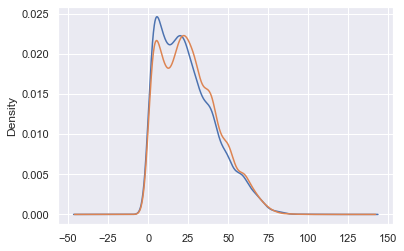

In [18]:
df_sub_F.age.plot(kind='density')
df_sub_M.age.plot(kind='density')

The histogram, however, doesn't gives us precise information about gender difference, for this we need to use the bootstrap procedure.

Bootstrapping looks as follows:

we will draw samples of size n from our data (effectively we treat our data are the population from which we take repeated samples)
for each sample, we compute and collect the statistic of interest (the mean) and put the observation back in our data (which is called with replacement)
We repeat steps 1-2 R times. 

This procedure will generate a distribution of the sample statistic: it conveys which values are consistent with the data, and which ones are unlikely to occur. Our estimate of the mean may contain error, and we'd like to compute how much variation we could expect due to random chance.


In code, it is easy to implement this procedure. In the `for` loop, we randomly sample 100 observations, compute the mean, and store this statistic in `mean_sampled`. We repeat this procedure 1000 times. 

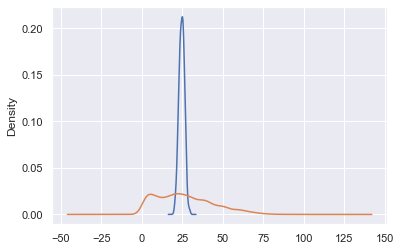

In [19]:
mean_sampled = []
for _ in range(100): # repeat code in block below 1000 times
    sample = df_sub_F['age'].sample(100) # randomly sample 100 observations
    mean_sampled.append(sample.mean()) # append mean of subsample
pd.Series(mean_sampled).plot(kind='density') # plot the sampling distribution a statistic
df_sub_M['age'].plot(kind='density') # plot the original data distribution

In this figure, we plotted the distribution of the sample statistic (blue) and the distribution of the original data (orange). Notice how different these distributions look: the sampling distribution of a statistic is narrower and centred around the mean. The phenomenon is often referred to as the **central limit theorem**: the sampling distribution of the mean will converge to a normal distribution,  which is a bell-shaped curve, with most of the values within two standard deviations from the mean. 

We will not provide a formal prove, but simuation using the bootstrap technique should suffice here. Below we take 1000 samples of size=1000 and plot the mean (red), one standard deviation (blue), and two standard deviations (red) to demonstrate that the sampling distribution of the mean is close to a normal distribution.

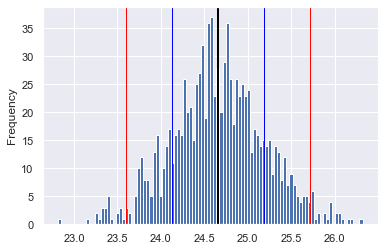

In [20]:
mean_sampled = []
for _ in range(1000): # repeat code in block below 1000 times
    sample = df_sub_F['age'].sample(1000) # randomly sample 1000 observations
    mean_sampled.append(sample.mean()) # append mean of subsample
ax = pd.Series(mean_sampled).plot(kind='hist',bins=100) # plot the sampling distribution a statistic

sdist_mean = pd.Series(mean_sampled).mean()
sdist_std = pd.Series(mean_sampled).std()

ax.axvline(x = sdist_mean, color='black', lw=2) # plot mean of distribution of the sampling statistic
ax.axvline(x = sdist_mean + sdist_std, color='blue', lw=1) # plot line one standard deviation from the mean
ax.axvline(x = sdist_mean - sdist_std, color='blue', lw=1) # plot line one standard deviation from the mean
ax.axvline(x = sdist_mean + (2*sdist_std), color='red', lw=1) # plot line two standard deviations from the mean
ax.axvline(x = sdist_mean - (2*sdist_std), color='red', lw=1) # plot line two standard deviations from the mean

After computing the sampling distribution of the mean for women in Whitechapel, we can easily obtain the 95% confidence interval, which implies that 95% all the possible means are locature withing this interval. We can apply `.quantile()` after converting the `mean_sampled` to a `pd.Series` object (you can not apply `.quantile()` a normal Python list. 


In [21]:
pd.Series(mean_sampled).quantile([0.025,0.975])

0.025    23.610825
0.975    25.713175
dtype: float64

The mean age of women is likely to vary between 23.6 and 25.7. We'd interpret this a range of values that are produced by random chance. The probability of observing more extreme values is lower then 0.05. 

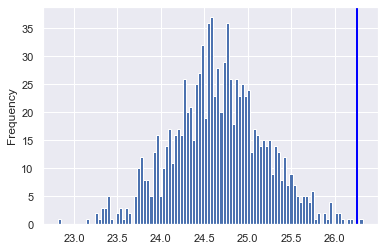

In [23]:
ax = pd.Series(mean_sampled).plot(kind='hist',bins=100) 
ax.axvline(x = df_sub_M['age'].mean(), color='blue', lw=2)

In [25]:
len([i for i in mean_sampled if i >= df_sub_M['age'].mean()]) / len(mean_sampled)

0.001

Please repeat this procedure for Poplar. In this case, the results should suggest that the mean age of men is well within the range of the sampling distribution of the mean computed for women.

## Permutation and Hypothesis Testing

The bootstrap is valuable for understanding the distribution of a sample statistics

The permutation test is valuable for hypothesis testing: central to the hypothesis test is the question of whether the differences we observe are the product of random chance? The latter will be our **null hypothesis**, namely that the age of men and women are essentially the same and that random chance explains the differences between the means. 

The alternative hypothesis serves as the "counterpoint" to the null hypothesis: the difference between the means is **not** the result of random chance. It is by rejecting the null hypothesis that we can accept the alternative hypothesis. 

In this sense, we never prove the alternative hypothesis directly but assume it is true because the null hypothesis is inconsistent with the data.

## The Permutation Procedure


The permutation follows a slightly different procedure than the bootstrap but also involves resampling from our data. 

1: We note the number of observations we have for each of our categories of interest (i.e. the number of women and men present in the data frame). Let calls these two groups `M` and `F` for convenience and `len(F)` is the number of observations for label or group `F`.

2: We combine the results into one data frame, which embodies the null hypothesis namely that, when it comes to age, the mean age of women and men are essentially the same, i.e. we can ignore the difference.

3: We shuffle the combined dataset (which mean randomizing the order of the rows) and take a sample of size `len(F)` (notice that this will contain data from both `M` and `F`.

4: The rows that remain are our second is a sample of `len(M)`

5: Now, we compute the mean for each sample,  take their difference, and record this number

6: We repeat step 2 till 5 a number times, let's say 1000, which will generate a distribution of permutation statistics. These statistics will tell what differences a random permutation of the data will generate, that ignores the difference between the categories of interest. In other words, these values are likely to occur if the null hypothesis were true.

Let's implement this procedure in code. First, we create three data frames: one for 'M', one for 'F' and one combined 'F' and 'M'.

In [27]:
regdist = 'Poplar'
df_sub_F = df[(df.gender=='F') & (df.district==regdist)]
df_sub_M = df[(df.gender=='M') & (df.district==regdist)]
df_sub_C = df[df.gender.isin(['F','M']) & (df.district==regdist)] 

In [28]:
df_sub_F.shape,df_sub_M.shape, df_sub_C.shape

((19993, 4), (19376, 4), (39369, 4))

For Poplar, the difference between means is approximately 0.2 years (women being younger than men). Is this result of random chance? What is the probability of observing this difference if we assume there exists no difference for this borough?

In [29]:
df_sub_F['age'].mean(),df_sub_M['age'].mean()

(26.38463462211774, 26.603168868703552)

In [30]:
df_sub_F['age'].mean() - df_sub_M['age'].mean()

-0.21853424658581133

To answer this question, we first record the number of observations for 'F' and then implement steps 2-5 in code.

In [31]:
num_F = df_sub_F.shape[0] # the number of observations for women
all_idx = set(df_sub_C.index) # get all indices

In [32]:
permutations = [] # initiate empty list to collect permutation statistics

for _ in tqdm(range(5000)): # we use tqmd to print the progress, running the permutation test can take a while
    f_idx = set(df_sub_C.sample(num_F).index) # take sample of size num_F and get index
    m_idx = all_idx - f_idx # get the remaining indices (rows not f_idx)
    diff_f_m_perm = df_sub_C.loc[f_idx]['age'].mean() - df_sub_C.loc[m_idx]['age'].mean() # diff between permuted statistics
    permutations.append(diff_f_m_perm) # append permutation statistic

Now we can plot the distribution of the permutation statistics, which indicates that if we don't assume any age differences between men and women in Poplar is likely between -0.6 and 0.6.

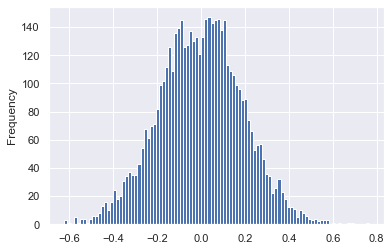

In [33]:
pd.Series(permutations).plot(kind='hist',bins=100)

The observed difference was -0.2 which is well the range of what we'd expect if the null hypothesis were true. In this case we don't have enough evidence to reject the null-hypothesis. 

Text(0, 0.5, 'Frequency')

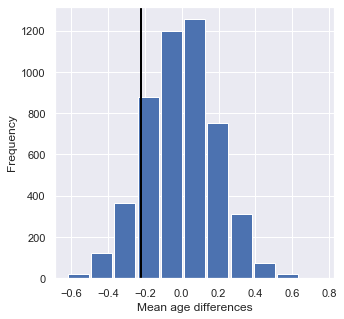

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(permutations, bins=11, rwidth=0.9)
ax.axvline(x = df_sub_F['age'].mean() - df_sub_M['age'].mean(), color='black', lw=2)
ax.set_xlabel('Mean age differences')
ax.set_ylabel('Frequency')

In this figure we compare the observed difference with distribution of the permuted differences. The black line shows the difference between the means we computed earlier. You'll notice that the oberved values is well within the set of permuated values.

Oftentimes, statistical analysis requires you to set a threshold value for rejecting the null hypothesis. As we're interested in the deviation from the general pattern—women being younger than men—we calculate how likely we encounter values equal to or smaller than the observed -0.2 under the null hypothesis. 


We can compute the probability of this scenario with values generated by the permutation test. Below we ask how likely are the compute differences equal to or smaller than -0.2.

In [35]:
len([i for i in permutations if i <= (df_sub_F['age'].mean() - df_sub_M['age'].mean())]) / len(permutations)

0.1282

A typical threshold value for rejecting the null hypothesis is 0.05 but this is a pure convention as nothing magically happens around this 0.05. In the social sciences, you'll often encounter 0.1 as the threshold, while in physics thresholds smaller than 0.00001 are common. Again this is a convention and changes by discipline or study.

In any case, you'll notice that the probability of the null hypothesis being true is around 0.13 (value may differ because of randomization, substantially above 0.05 and therefore we can not accept the difference as statistically significant.

The result of the permuation test is largely similar to the Student's t-test. The p-value in this case is the probability of observed values equal to or lower than the observed difference, assuming there is no difference between men amd womenin the sample (a one-side t-test).

In [36]:
from scipy.stats import ttest_ind
ttest_ind(df_sub_F['age'],df_sub_M['age'],alternative='less')

Ttest_indResult(statistic=-1.151420997318941, pvalue=0.12478303628250077)

You can repeat the permutation for Whitechapel. In this case, the age difference should be highly significant.

## Gender and Disability
### An additional example

We can also use permutation to test the relation between categorical variables: in this case we study the relation gender and disability as reported in our census sample.

In [37]:
p = df.sample(frac=.1).groupby('gender')['disability'].agg([np.sum, len])

In [38]:
p['no_disability']  = p['len'] - p['sum']

In [39]:
p.rename({'sum':'disability','len':'all'},axis=1,inplace=True)

In [40]:
p_t = p.T
p_t

gender,F,M,U
disability,242,228,87
all,57862,48640,4022
no_disability,57620,48412,3935


In [41]:
p_t.loc[['disability','no_disability'],['F','M']]

gender,F,M
disability,242,228
no_disability,57620,48412


In [42]:
def permutation_function(x, size_df_1, size_df_2):
    size_all = size_df_1 + size_df_2
    idx_2 = set(random.sample(range(size_all), size_df_2))
    idx_1 = set(range(size_all)) - idx_2
    return x.loc[idx_2].mean() - x.loc[idx_1].mean()

In [43]:
obs_f = p_t.loc['disability','F'] / p_t.loc['all','F']
obs_m = p_t.loc['disability','M'] / p_t.loc['all','M']

In [44]:
obs_pct_diff = 100 * (obs_f - obs_m)
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: -0.0505%


In [45]:
conv = [0] * (p_t.loc['no_disability','F']+p_t.loc['no_disability','M'])
len(conv)

106032

In [46]:
conv.extend([1] * (p_t.loc['disability','F']+p_t.loc['disability','M']))
conv_series = pd.Series(conv)
conv_series

0         0
1         0
2         0
3         0
4         0
         ..
106497    1
106498    1
106499    1
106500    1
106501    1
Length: 106502, dtype: int64

In [47]:
perm_diffs = [100 * permutation_function(conv_series,  p_t.loc['all','F'],  p_t.loc['all','M']) for _ in tqdm(range(1000))]

Text(0, 0.5, 'Frequency')

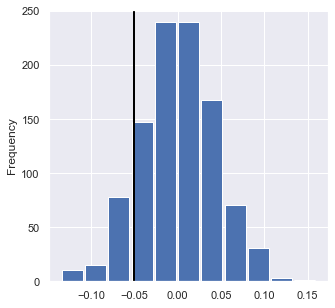

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.set_ylabel('Frequency')

In [49]:
(len([i for i in perm_diffs if (i <= obs_pct_diff)]) / len(perm_diffs))*2

0.234

In [50]:
from scipy import stats
survivors = np.array([[p_t.loc['disability','F'], p_t.loc['no_disability','F']], 
                      [p_t.loc['disability','M'], p_t.loc['no_disability','M']]])
chi2, p_value, _, _ = stats.chi2_contingency(survivors)
print(f'p-value : {p_value*2 / 2:.8f}')

p-value : 0.23309297


# Fin.